# 20221130 Image Processing: Chamber Finding with eGFP "Bright Field" image

I have been able to locate chambers using SYPRO images, but now want to see if i can use psuedo-brightfield images to find all chambers _regardless_ of fluorescence.
To do this I will neeed to exclude lagoons, and make sure that I also find buttons.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings
import skimage
import glob
import imutils
from sklearn.linear_model import LinearRegression
import math
from copy import deepcopy
import pandas as pd

### Chamber location function
___

In [2]:
def find_chambers(img_path: str, chamber_rad: int, outer_chamber_bound: int, circle_param_1: int, circle_param_2: int):

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # with warnings.catch_warnings():
    #     warnings.simplefilter("ignore") # Will throw warning due to precision loss
    #     cimg = skimage.img_as_ubyte(img, force_copy = True)
        
    # searchRadii
    min_rad = chamber_rad
    max_rad = min_rad + outer_chamber_bound

    # find circles
    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,2,10,param1=circle_param_1,param2=circle_param_2, minRadius=min_rad, maxRadius=max_rad)

    grad_threshold = circle_param_1
    # If no circles found, loosen gradient threshold
    while type(circles) is not np.ndarray and grad_threshold > 5:
        circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,2,10,param1=grad_threshold, param2=circle_param_2, minRadius=min_rad+1, maxRadius=max_rad+2)
        grad_threshold -= 1

    # If still none found, return a blank chamber (failed)
    if not np.any(circles): 
        m = 'No chamber border found'
        warnings.warn(m)

    return circles[0]    

In [3]:
def get_rotation_adjustment(chamber_array: np.array, aligned_threshold: int = 75):
    # get left most 3 wells (min x-axis)
    min_x_chambers = chamber_array[chamber_array[:,0].argsort()[:3]]
    # remove radii
    min_x_chamber_coords = min_x_chambers[:,:2]
    # fit first pass model
    model = LinearRegression().fit(min_x_chamber_coords[:,0].reshape(-1,1), min_x_chamber_coords[:,1])

    pred_errors = model.predict(chamber_array[:,0].reshape(-1,1)) - chamber_array[:,1]

    updated_min_x_chambers = chamber_array[np.argwhere(pred_errors < aligned_threshold)].reshape(-1,3)

    updated_model = LinearRegression().fit(updated_min_x_chambers[:,0].reshape(-1,1), updated_min_x_chambers[:,1])

    rotation_angle = math.atan(updated_model.coef_)

    return rotation_angle


# Find Chambers from Brighftield

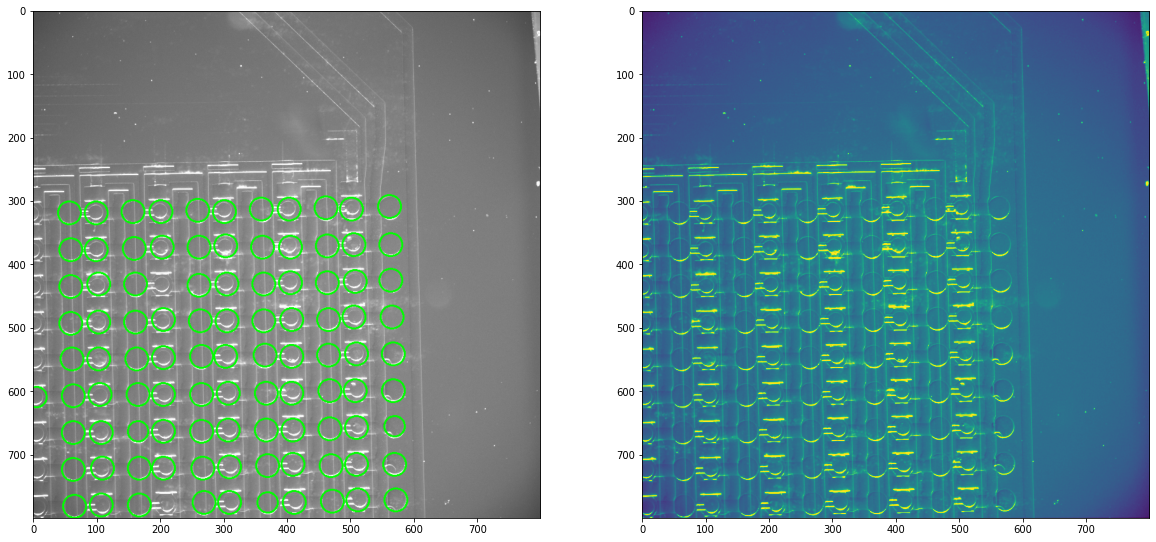

In [22]:
chamber_rad = 15
outer_chamber_bound = 4
circle_param_1 = 50
circle_param_2 = 40
grid_coords_raw = []


f, axarr = plt.subplots(1,2, figsize=(20,10))
rotation_angle = None

img_path = "/Volumes/DuncanSSD/20221130/20221130-084247-d1_real-egfp-50-brightfield_egfp_50_Sola_4x4_Kinetix-DynamicRange_4x/egfp/20221130-084247_real-egfp-50-brightfield_egfp_50_Sola_4x4_Kinetix-DynamicRange_4x_egfp/3-Pos000_000_50.tif"
    
# find circles in image
circles = find_chambers(img_path=img_path, chamber_rad=chamber_rad, outer_chamber_bound=outer_chamber_bound, circle_param_1=circle_param_1, circle_param_2=circle_param_2)

# find rotation adjustment
if rotation_angle is None:
    rotation_angle = get_rotation_adjustment(circles)

# get image dimensions
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
full_color_img = cv2.imread(img_path)

# Draw detected circles
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles:
        # outer circle
        ## cv2.circle(image, center_coordinates, radius, color, thickness)
        cv2.circle(full_color_img, (i[0], i[1]), i[2], (0, 255, 0), 2)
output_image = imutils.rotate(img, angle=-rotation_angle)

axarr[1].imshow(output_image)  
axarr[0].imshow(full_color_img)

# Find Buttons from Brighftield

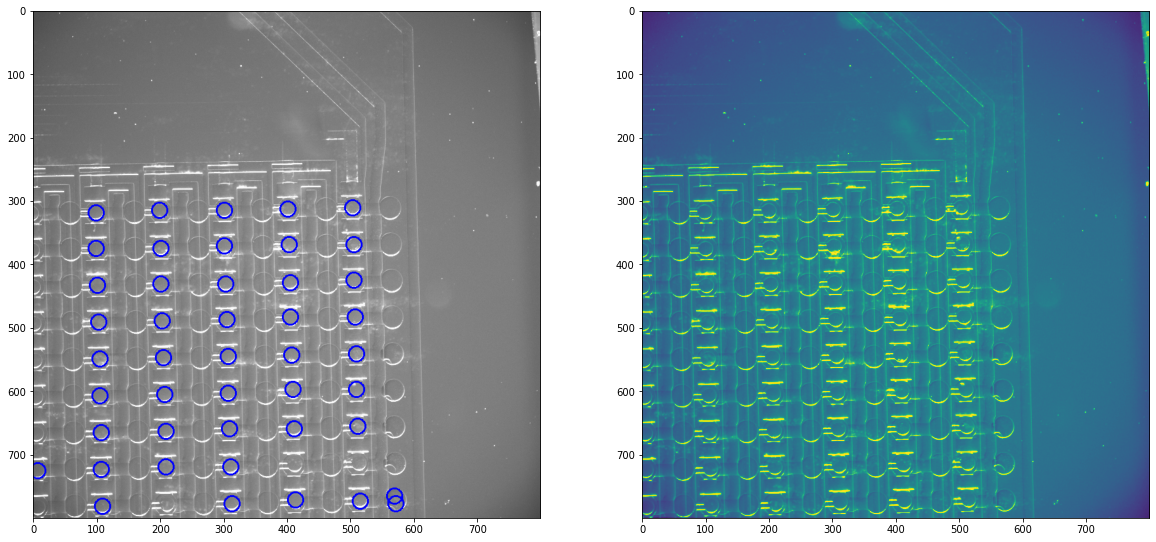

In [23]:
chamber_rad = 10
outer_chamber_bound = 3
circle_param_1 = 50
circle_param_2 = 40
grid_coords_raw = []


f, axarr = plt.subplots(1,2, figsize=(20,10))
rotation_angle = None

img_path = "/Volumes/DuncanSSD/20221130/20221130-084247-d1_real-egfp-50-brightfield_egfp_50_Sola_4x4_Kinetix-DynamicRange_4x/egfp/20221130-084247_real-egfp-50-brightfield_egfp_50_Sola_4x4_Kinetix-DynamicRange_4x_egfp/3-Pos000_000_50.tif"
    
# find circles in image
circles = find_chambers(img_path=img_path, chamber_rad=chamber_rad, outer_chamber_bound=outer_chamber_bound, circle_param_1=circle_param_1, circle_param_2=circle_param_2)

# find rotation adjustment
if rotation_angle is None:
    rotation_angle = get_rotation_adjustment(circles)

# get image dimensions
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
full_color_img = cv2.imread(img_path)

# Draw detected circles
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles:
        # outer circle
        ## cv2.circle(image, center_coordinates, radius, color, thickness)
        cv2.circle(full_color_img, (i[0], i[1]), i[2], (0, 0, 255), 2)
output_image = imutils.rotate(img, angle=-rotation_angle)

axarr[1].imshow(output_image)  
axarr[0].imshow(full_color_img)

Well i can get the rough column coordinates here, but this is done aggregating all of the images together, so I need to figure out how best to store these on a per image basis

## First find circles and assign rows

In [79]:
chamber_rad = 14
outer_chamber_bound = 5
circle_param_1 = 50
circle_param_2 = 40

grid_coords_raw = []
local_coords = []
img_cols = []
img_rotations = []

for idx, img_path in enumerate(sorted(glob.glob("../../data/20221116-225340_sypro5Murea_equil_20min_egfp_500_Sola_4x4_Kinetix-DynamicRange_4x_egfp/*Pos00*_000_500.tif"),reverse=True)):
    
    # find circles in image
    circles = find_chambers(img_path=img_path, chamber_rad=chamber_rad, outer_chamber_bound=outer_chamber_bound, circle_param_1=circle_param_1, circle_param_2=circle_param_2)

    rotation_angle = get_rotation_adjustment(circles)

    # get image dimensions
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_x_dim, img_y_dim = img.shape

    # remove redundant chambers (in 10% overlap)
    if idx > 0:
       circles = circles[circles[:,0] < (img_x_dim - img_x_dim/10)]

    img_cols.extend([idx]*len(circles))
    img_rotations.extend([rotation_angle]*len(circles))
    adjusted_x_circles = deepcopy(circles)
    adjusted_x_circles[:,0] += idx*(img_x_dim - img_x_dim/10)
    local_coords.extend(circles)
    grid_coords_raw.extend(adjusted_x_circles)   

coord_arr = np.array(grid_coords_raw)
local_coord_arr = np.array(local_coords)
x_coords = deepcopy(coord_arr[:,0])
x_coords -= min(x_coords)

COL_COUNT = 32
col_width = max(x_coords) / (COL_COUNT - 1)

chamber_df = pd.DataFrame({"img_col": img_cols,
 "chamber_x": local_coord_arr[:,0], 
 "chamber_y": local_coord_arr[:,1],
 "chamber_rad": local_coord_arr[:,2],
 "grid_col": np.around(x_coords / col_width),
 "img_rotations": img_rotations})


[4.00572920e+00 4.02546167e+00 4.99236155e+00 1.99299812e+00
 1.06556332e+00 2.97963095e+00 2.03246355e+00 2.05219603e+00
 4.97262907e+00 1.08529603e+00 3.07829428e+00 5.01209450e+00
 9.86632764e-01 1.04583073e+00 3.09802675e+00 3.98599625e+00
 5.07129240e+00 3.01909614e+00 2.01273084e+00 5.05155945e+00
 1.97326541e-02 4.06492710e+00 5.09102488e+00 1.10502863e+00
 3.03882885e+00 5.91979660e-02 1.02609801e+00 3.94653082e-02
 2.07192874e+00 3.11775947e+00 4.04519415e+00 0.00000000e+00
 2.09166145e+00 3.03882885e+00 1.12476134e+00 2.13112664e+00
 4.10439205e+00 7.89306164e-02 4.10439205e+00 1.18395932e-01
 6.98535967e+00 8.99809074e+00 1.09910889e+01 1.00241890e+01
 1.09713564e+01 1.09516239e+01 1.10108213e+01 1.20369196e+01
 1.00044565e+01 8.95862579e+00 6.01845980e+00 8.03119087e+00
 9.01782322e+00 9.96499062e+00 1.00439215e+01 6.03819227e+00
 1.10305538e+01 1.19579887e+01 9.94525814e+00 1.19974546e+01
 5.97899437e+00 6.96562719e+00 8.01145840e+00 6.07765770e+00
 1.00636539e+01 6.057925

## Draw circles on image with column labels

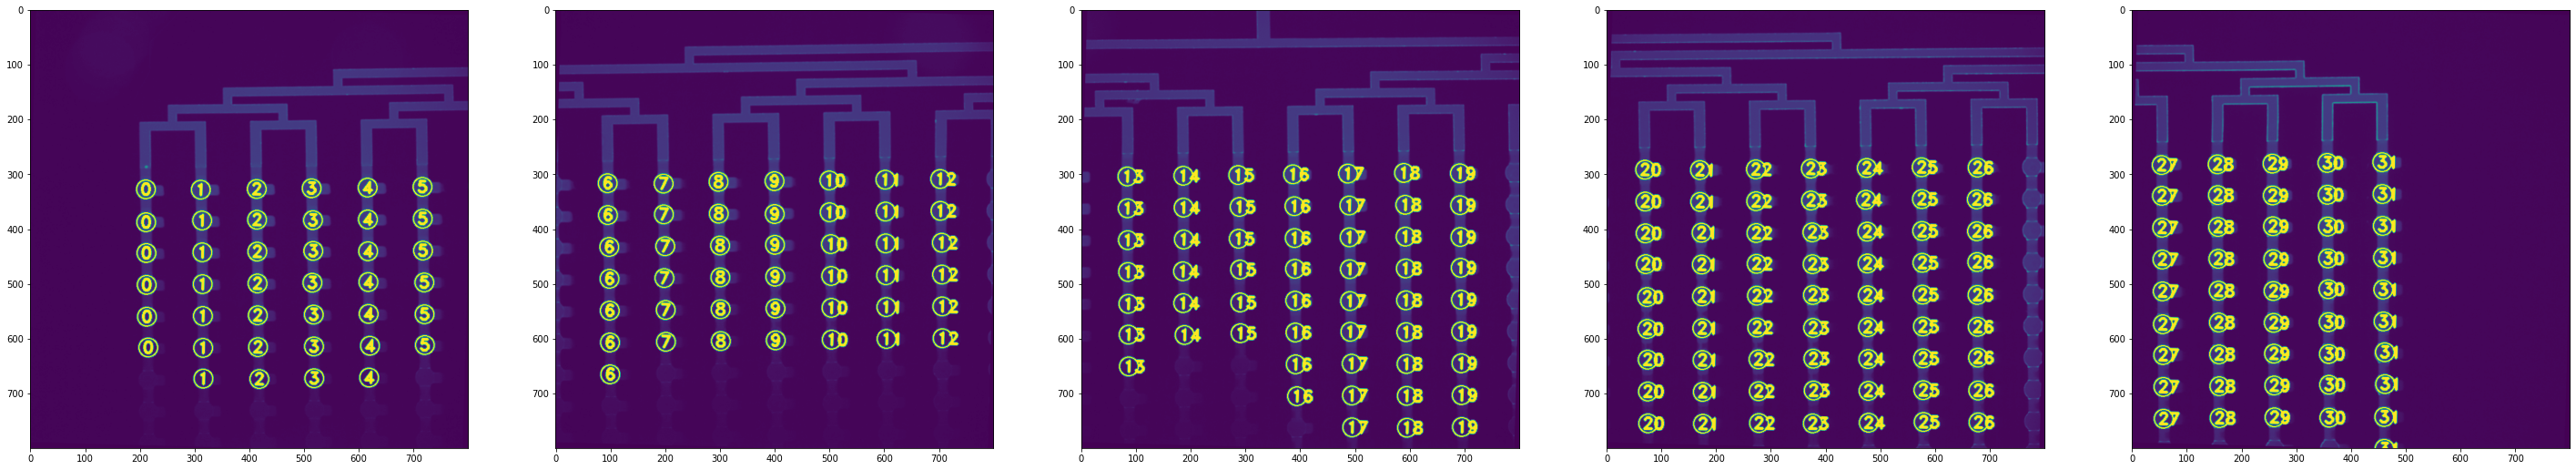

In [83]:
f, axarr = plt.subplots(1,5, figsize=(50,10))
IMG_TEXT_OFFSET =10
for idx, img_path in enumerate(sorted(glob.glob("../../data/20221116-225340_sypro5Murea_equil_20min_egfp_500_Sola_4x4_Kinetix-DynamicRange_4x_egfp/*Pos00*_000_500.tif"),reverse=True)):
    
    # get image dimensions
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
   
    for _, chamber in chamber_df[chamber_df["img_col"] == idx].iterrows():
        cham_x = int(chamber["chamber_x"])
        cham_y = int(chamber["chamber_y"])
        cham_rad = int(chamber["chamber_rad"])

        cv2.circle(img, (cham_x, cham_y), cham_rad, (255, 0, 0), 2)
        cv2.putText(img,
        text = str(int(chamber["grid_col"])),
        org = (cham_x - IMG_TEXT_OFFSET, cham_y+ IMG_TEXT_OFFSET),
        fontFace = cv2.FONT_HERSHEY_DUPLEX,
        fontScale = 1.0,
        color = (255, 0, 0),
        thickness = 3
        )
    output_image = imutils.rotate(img, angle=-rotation_angle)

    axarr[idx].imshow(output_image)  